# DETECTING MALICIOUS URL IN REAL-TIME USING MACHINE LEARNING

## Importing Libraries

In [1]:
import re
import string
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from urllib.parse import urlparse
import tldextract
from tld import get_tld
import pycountry_convert as pc

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn. feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

import xgboost as xgb
from lightgbm import LGBMClassifier

from tensorflow.keras.utils import to_categorical # error: ignore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam 

import joblib





## Loading Dataset

In [2]:
url_df = pd.read_csv("data/malicious_phish.csv")
url_df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


## DATA PROCESSING

In [3]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


### Checking Duplicates

In [4]:
int(url_df.duplicated().sum())

10066

### Removing Duplicates

In [5]:
url_df.drop_duplicates(inplace=True, ignore_index=True)

### Plotting Type Count

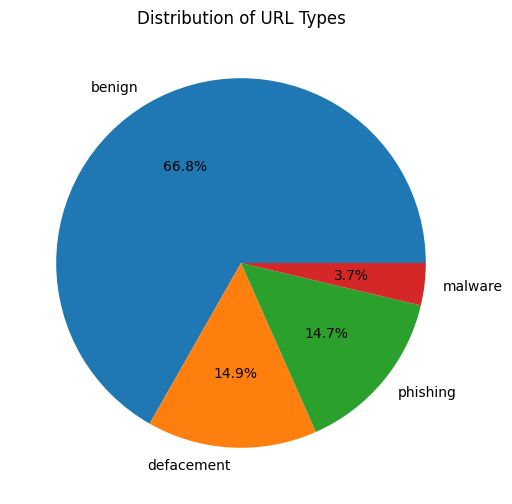

In [6]:
url_df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 6), title='Distribution of URL Types', ylabel="")
plt.show()

### Plotting Word Cloud

#### Benign

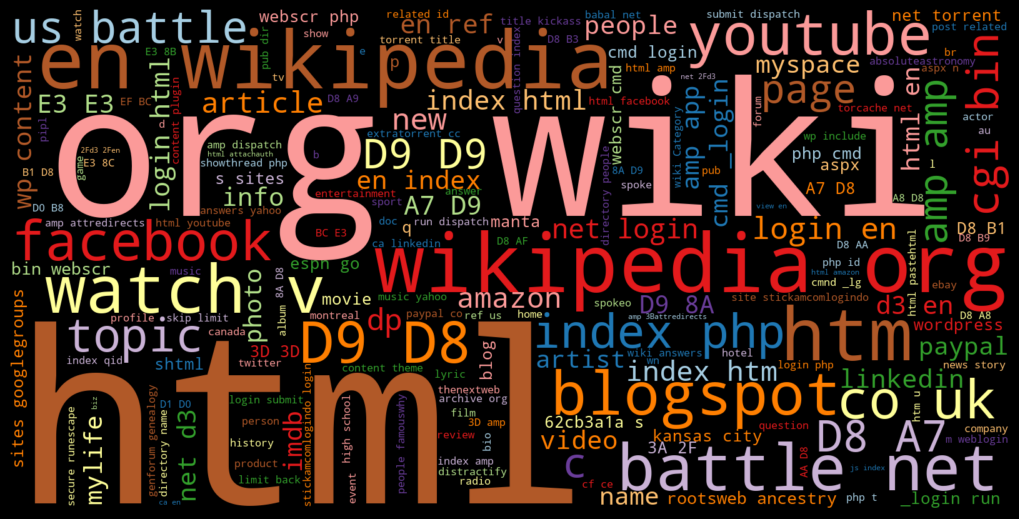

In [7]:
df_benign = url_df[url_df['type'] == 'benign']
benign_url = " ".join(i for i in df_benign['url'])
wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Paired').generate(benign_url)
plt.figure(figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Phishing

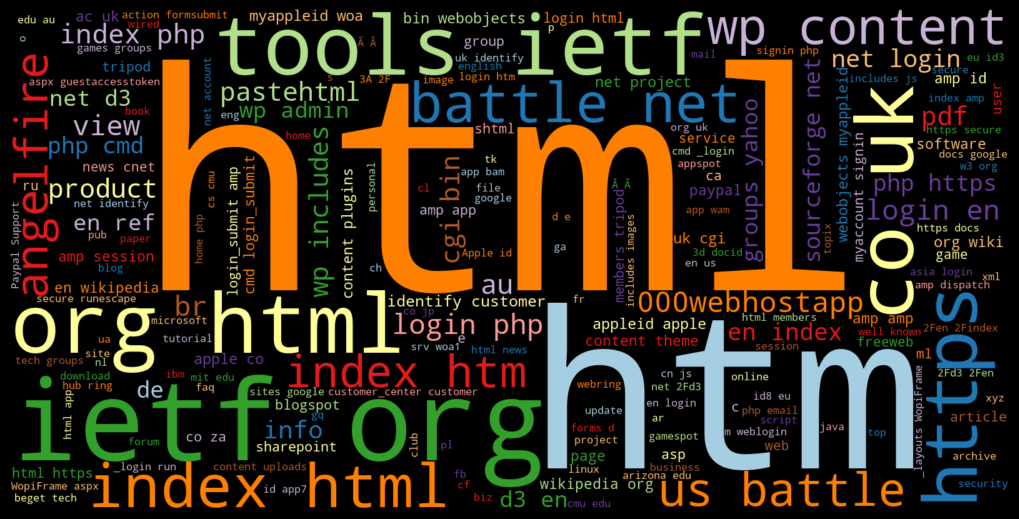

In [8]:
df_phishing = url_df[url_df['type'] == 'phishing']
phish_url = " ".join(i for i in df_phishing['url'])
wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Paired').generate(phish_url)
plt.figure(figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Malware

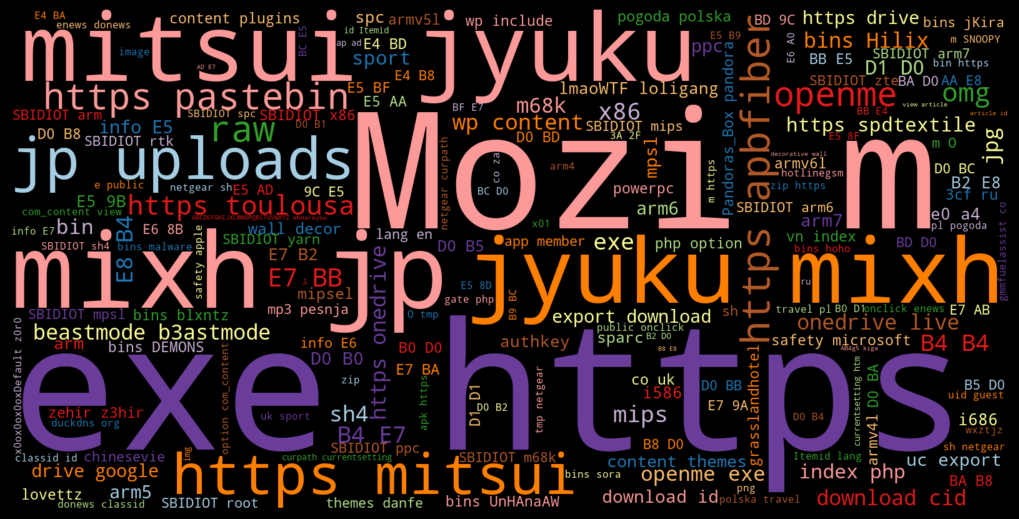

In [9]:
df_malware = url_df[url_df['type'] == 'malware']
malware_url = " ".join(i for i in df_malware['url'])
wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Paired').generate(malware_url)
plt.figure(figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Defacement

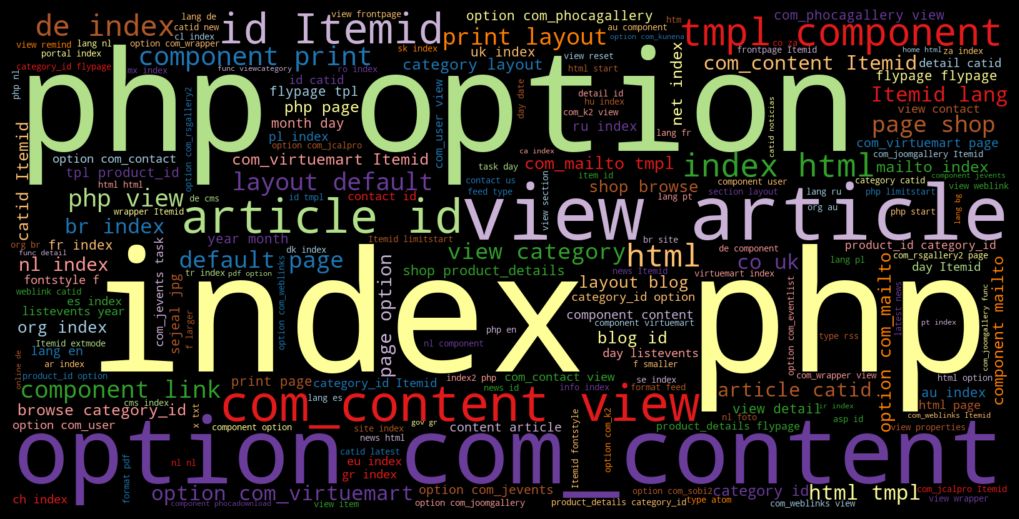

In [10]:
df_defacement = url_df[url_df['type'] == 'defacement']
defacement_url = " ".join(i for i in df_defacement['url'])
wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Paired').generate(defacement_url)
plt.figure(figsize=(10, 5), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## FEATURE EXTRACTION

In [11]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

url_df['url_len'] = url_df['url'].apply(lambda x: get_url_length(str(x)))

In [12]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

url_df['root_domain'] = url_df['url'].apply(lambda x: extract_root_domain(x))

In [13]:
def root_domain_length(root_domain):
    if root_domain:
        return len(root_domain)
    return 0

url_df['root_domain_length'] = url_df['root_domain'].apply(lambda x: root_domain_length(x))

In [14]:
def hostname_length(url):
    return len(urlparse(url).netloc)

url_df['hostname_length']=url_df['url'].apply(lambda i: hostname_length(i))

In [15]:
def get_subdomain(url):
    try:
        parsed_url = urlparse(url)
        subdomain = parsed_url.hostname.split('.')[0] if parsed_url.hostname else ''
        return subdomain
    except Exception as e:
        return None  
    
url_df['subdomain'] = url_df['url'].apply(lambda x: get_subdomain(x))  

In [16]:
def subdomain_length(url):
    subdomain = get_subdomain(url)
    return len(subdomain) if subdomain else 0

url_df['subdomain_length'] = url_df['url'].apply(lambda x: subdomain_length(x))

In [17]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

url_df['pri_domain'] = url_df['url'].apply(lambda x: extract_pri_domain(x))

In [18]:
def pri_domain_length(url):
    if url is not None:
        return len(urlparse(url).netloc.split('.')[0])
    else:
        return 0
    
url_df['pri_domain_length'] = url_df['pri_domain'].apply(lambda x: pri_domain_length(x))

In [19]:
def shortening_service(url):
        match = re. search( r'bit\.ly|goo\.gl|shorte\.st|go21\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                            r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|ur14\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                            r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                            r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|o\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                            r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                            r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                            r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                            r'tr\.im|link\.zip\.net',
                            url)

        if match:
            return 1
        else:
            return 0

url_df['short_url'] = url_df['url'].apply(lambda i: shortening_service(i))

In [20]:
def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

url_df['num_special_chars'] = url_df['url'].apply(lambda x: count_special_chars(str(x)))

In [21]:
def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

url_df['num_digits'] = url_df['url'].apply(lambda x: count_digits(str(x)))

In [22]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

url_df['num_letters'] = url_df['url'].apply(lambda x: count_letters(str(x)))

In [23]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

url_df['secure_http'] = url_df['url'].apply(lambda x: secure_http(x))

In [24]:
def having_ip_address(url):
    # Combined regex for IPv4, IPv4 (hex), and IPv6
    ip_pattern = re.compile(
        r'((25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}'
        r'(25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)'                      # IPv4
        r'|((0x[0-9a-fA-F]{1,2})\.){3}(0x[0-9a-fA-F]{1,2})'        # IPv4 in hex
        r'|([a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}'                 # IPv6
    )
    
    return 1 if ip_pattern.search(url) else 0

url_df['use_of_ip'] = url_df['url'].apply(having_ip_address)


In [25]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

url_df['region'] = url_df['pri_domain'].apply(lambda x: get_url_region(x) if x else "Unknown")

In [26]:
def get_continent(country_name):
    try:
        # Convert country name to ISO alpha-2 code
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        # Get continent code from country code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Map to full continent name
        continent_name = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }[continent_code]
        return continent_name
    except:
        return 'Unknown'

# Apply function to the DataFrame
url_df['continent'] = url_df['region'].apply(get_continent)

In [27]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re. search(hostname, url)

    if match:
    # print match.group()
        return 1
    else:
    # print 'No matching pattern found'
        return 0

url_df['abnormal_url'] = url_df['url'].apply(lambda i: abnormal_url(i))

In [28]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

url_df['count_dir']=url_df['url'].apply(lambda i: no_of_dir(i))

In [29]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

url_df['count_embed_domian']= url_df['url'].apply(lambda i: no_of_embed(i))

In [30]:
def custom_hash_encode(category):
    hash_value = 5381  # Initial prime number
    for char in category:
        hash_value = ((hash_value << 5) + hash_value) + ord(char)  # hash * 33 + ord(char)
    return hash_value % (10 ** 8)

url_df['hash_region'] = url_df['region'].apply(lambda x: custom_hash_encode(x))
url_df['hash_root_domain'] = url_df['root_domain'].apply(lambda x: custom_hash_encode(x) if x else 0)
url_df['hash_continent'] = url_df['continent'].apply(lambda x: custom_hash_encode(x))

### Exploratory Data Analysis (EDA)

In [31]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641125 entries, 0 to 641124
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 641125 non-null  object
 1   type                641125 non-null  object
 2   url_len             641125 non-null  int64 
 3   root_domain         641125 non-null  object
 4   root_domain_length  641125 non-null  int64 
 5   hostname_length     641125 non-null  int64 
 6   subdomain           641125 non-null  object
 7   subdomain_length    641125 non-null  int64 
 8   pri_domain          628910 non-null  object
 9   pri_domain_length   641125 non-null  int64 
 10  short_url           641125 non-null  int64 
 11  num_special_chars   641125 non-null  int64 
 12  num_digits          641125 non-null  int64 
 13  num_letters         641125 non-null  int64 
 14  secure_http         641125 non-null  int64 
 15  use_of_ip           641125 non-null  int64 
 16  re

### 1. Distribution of use of IP

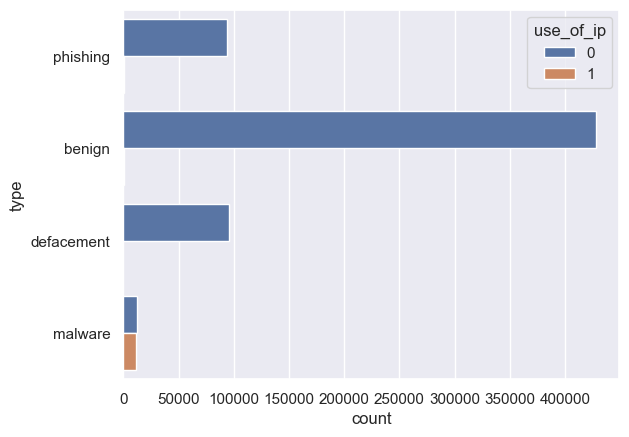

In [32]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=url_df, hue="use_of_ip")

### 2. Distribution of Abnormal URL

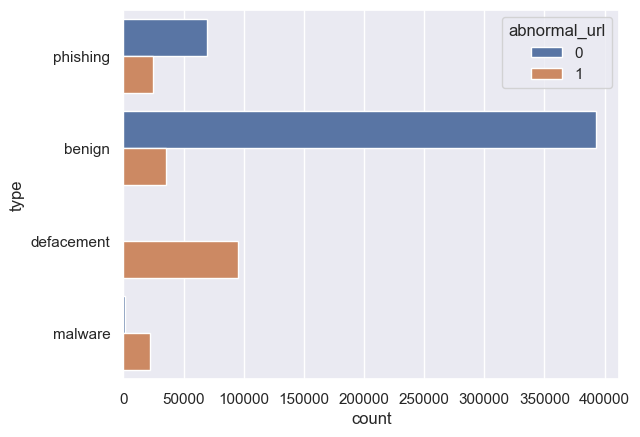

In [33]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=url_df, hue="abnormal_url")

### 4. Distribution of Short URL

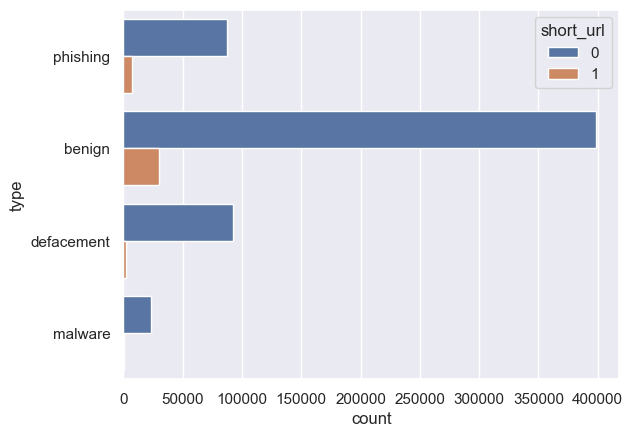

In [34]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=url_df, hue="short_url")


### 5. Distribution of Special Characters

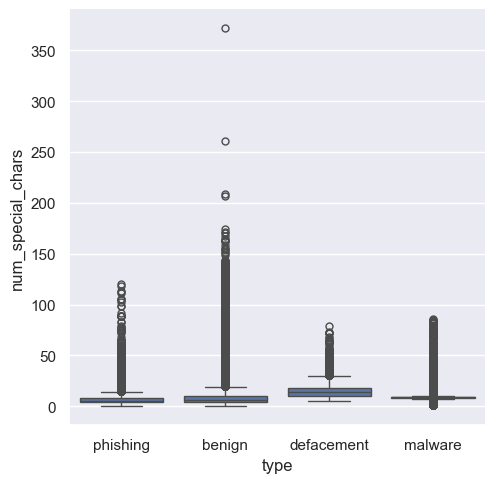

In [35]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="num_special_chars", kind="box", data=url_df)

### 6. Distribution of Directories

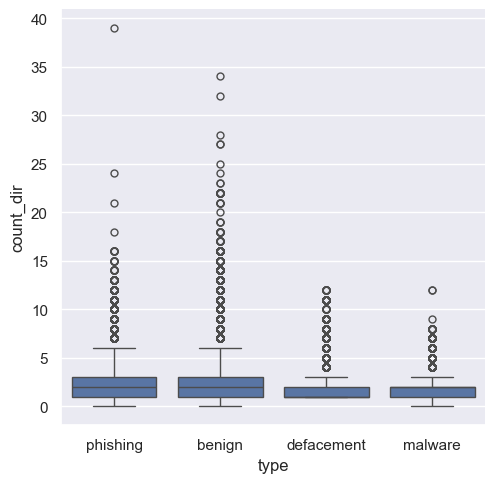

In [36]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=url_df)

### 7. Distribution of Embedded Domain

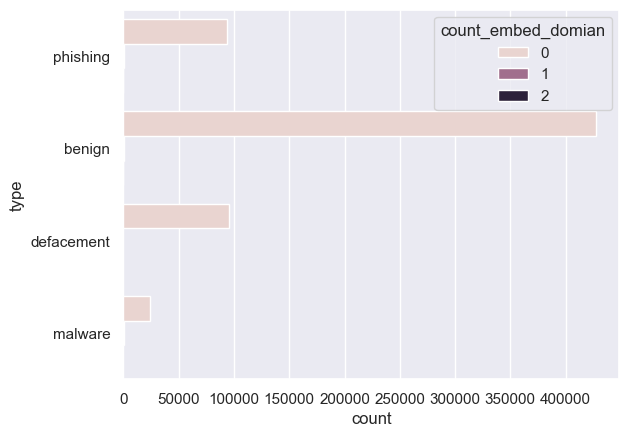

In [37]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=url_df, hue="count_embed_domian")

### 8. Distribution of Secure `http`

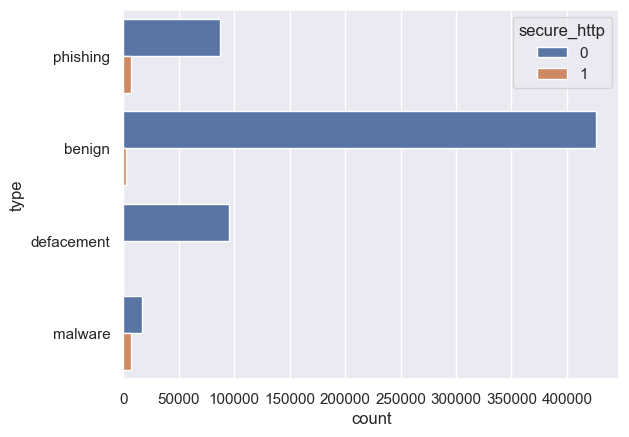

In [38]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=url_df, hue="secure_http")

### 9. Distribution of Letters

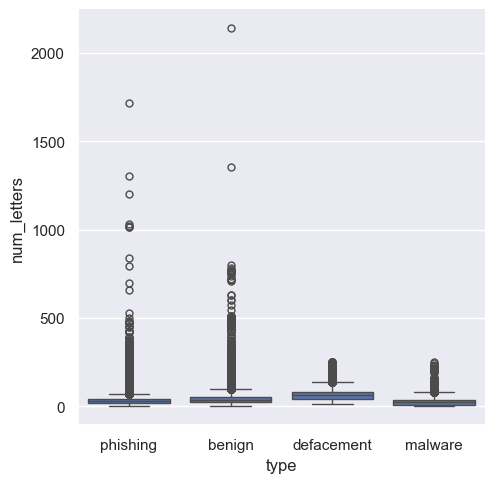

In [39]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="num_letters", kind="box", data=url_df)

### 10. Distribution of Numbers

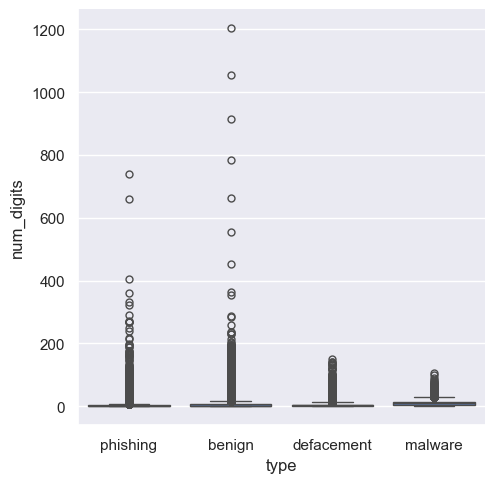

In [40]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="num_digits", kind="box", data=url_df)

### 11. Distribution of Pri-Domain

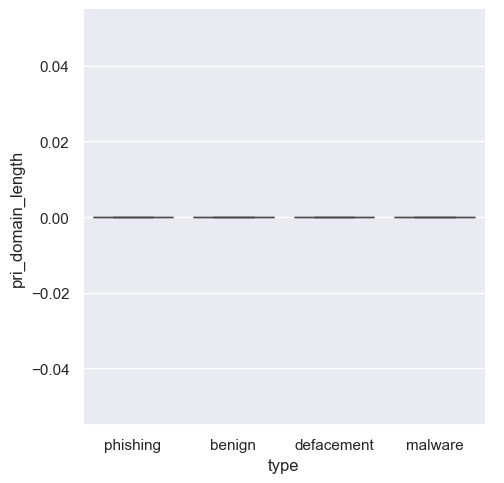

In [41]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="pri_domain_length", kind="box", data=url_df)

### 12. Distribution of Domain

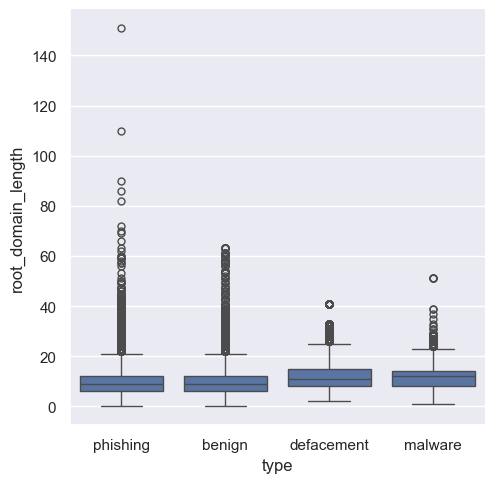

In [42]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="root_domain_length", kind="box", data=url_df)

### 13. Distribution of Subdomain

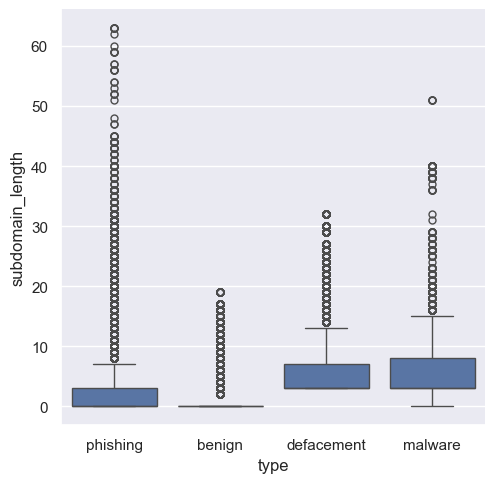

In [43]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="subdomain_length", kind="box", data=url_df)

### 14. Distribution of Hostname

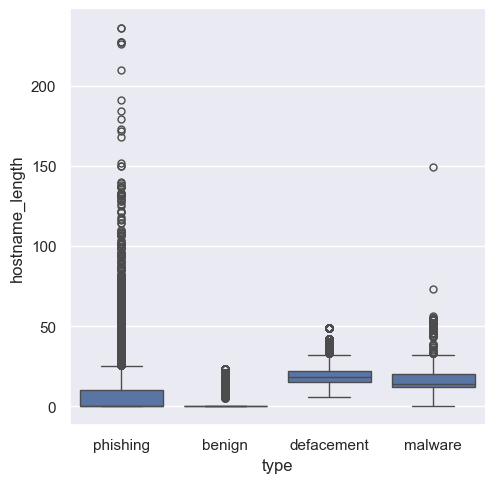

In [44]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=url_df)

### 15. Distribution of URL

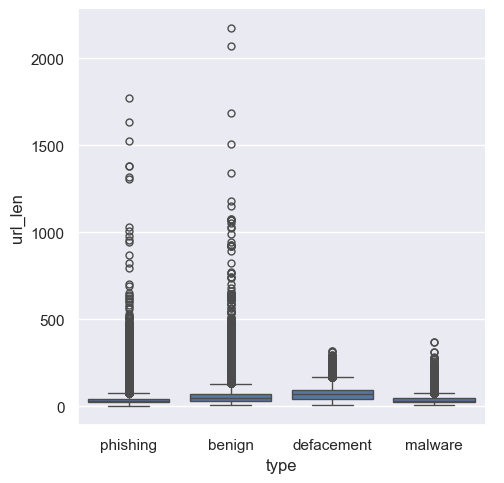

In [45]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="url_len", kind="box", data=url_df)

### 16. Distribution of Continent

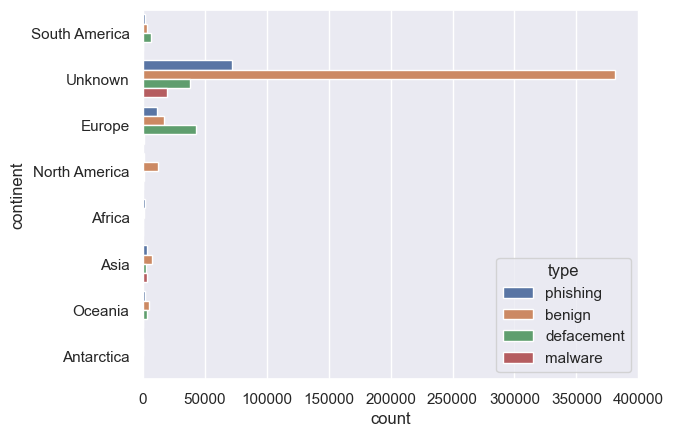

In [46]:
sns.set(style="darkgrid")
ax = sns.countplot(y="continent", data=url_df, hue="type")

### Target Encoding

In [47]:
le = LabelEncoder()
url_df['label'] = le.fit_transform(url_df['type'])

### Feature and Target

In [48]:
selected_features = url_df.drop(columns=['url', 'type', 'region', 'root_domain', 'pri_domain', 'pri_domain_length', 'subdomain', 'count_embed_domian', 'label', 'continent']).columns.tolist()

X = url_df[selected_features]
y = url_df['label']

### Feature Scaling

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Train Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)

## Model Building

In [51]:
# Model Training
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [52]:
# Hyperparameter tuning
rf_grid = {"n_estimators": [100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5]}
gb_grid = {"n_estimators": [100, 200]}

### 1. Random Forest Classifier

#### a.) Using base model

In [53]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')

start_train = time.time()
rf.fit(X_train,y_train)
end_train = time.time()
print("Training time for Random Forest: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_rf = rf.predict(X_test)
end_test = time.time()
print("Testing time for Random Forest: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = accuracy_score(y_test, y_pred_rf)
print("accuracy: %0.3f" % score)

Training time for Random Forest: 81.595 seconds
Testing time for Random Forest: 5.181 seconds
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85616
  defacement       0.97      0.99      0.98     19062
    phishing       0.96      0.92      0.94      4729
     malware       0.92      0.83      0.87     18818

    accuracy                           0.96    128225
   macro avg       0.96      0.93      0.94    128225
weighted avg       0.96      0.96      0.96    128225

accuracy: 0.964


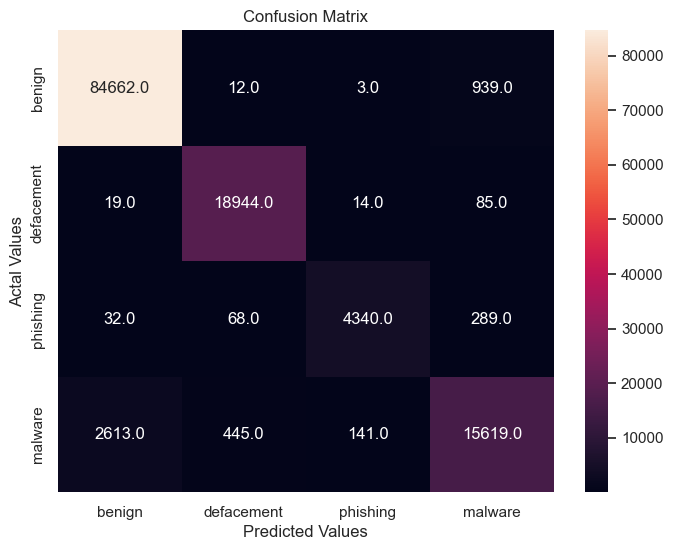

In [54]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                    index = ['benign', 'defacement','phishing','malware'],
                    columns = ['benign', 'defacement','phishing','malware'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt. show()

In [87]:
feature_names = X.columns.tolist()
joblib.dump((rf, feature_names), 'models/rf_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

<Axes: >

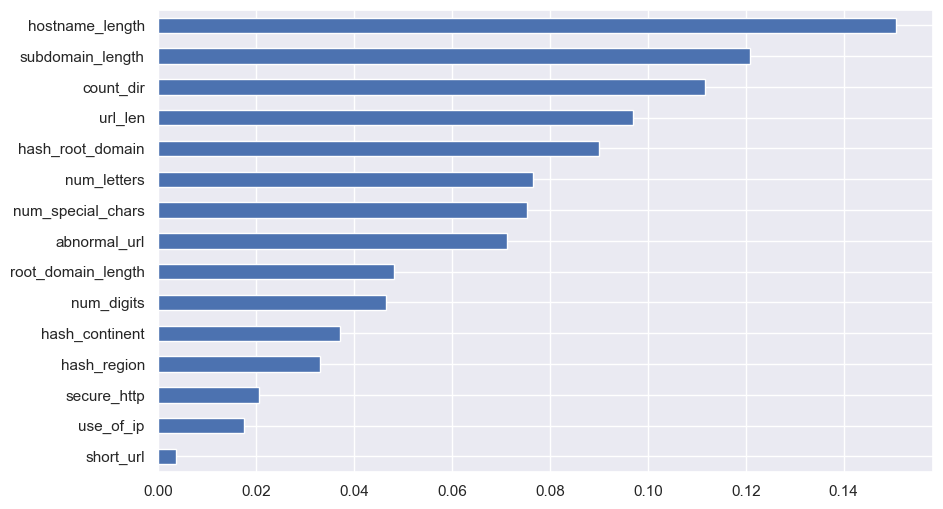

In [55]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances. sort_values().plot(kind="barh",figsize=(10,6))

#### Feature Selection

In [58]:
feature_selector = SelectKBest(score_func=f_classif, k=10)

X_new = feature_selector.fit_transform(X_scaled, y)
selected_features_indices = feature_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]

print("Selected features after ANOVA F-test:", selected_features.tolist())


Selected features after ANOVA F-test: ['url_len', 'hostname_length', 'subdomain_length', 'num_special_chars', 'num_letters', 'secure_http', 'use_of_ip', 'abnormal_url', 'hash_region', 'hash_continent']


#### Training on selected features

In [60]:
# Train a Random Forest model with selected features
X_train_selected = X_train[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

rf_selected = RandomForestClassifier(n_estimators=100, max_features='sqrt')

start_train = time.time()
rf_selected.fit(X_train_selected, y_train)
end_train = time.time()

print("Training time for Random Forest with selected features: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_rf_selected = rf_selected.predict(X_test_selected)
end_test = time.time()

print("Testing time for Random Forest with selected features: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test, y_pred_rf_selected, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = accuracy_score(y_test, y_pred_rf_selected)
print("accuracy: %0.3f" % score)

Training time for Random Forest with selected features: 42.970 seconds
Testing time for Random Forest with selected features: 2.599 seconds
              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85616
  defacement       0.94      0.97      0.95     19062
    phishing       0.96      0.89      0.92      4729
     malware       0.87      0.69      0.77     18818

    accuracy                           0.93    128225
   macro avg       0.93      0.88      0.90    128225
weighted avg       0.93      0.93      0.93    128225

accuracy: 0.935


#### b.) Using Grid Search

In [61]:
grid_search_rf = GridSearchCV(RandomForestClassifier(), rf_grid, cv=2)

start_train = time.time()
rf_best = grid_search_rf.fit(X_train, y_train)
end_train = time.time()
print("Training time for Random Forest with Grid Search: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_rf_best = rf_best.predict(X_test)
end_test = time.time()
print("Testing time for Random Forest with Grid Search: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test, y_pred_rf_best, target_names=['benign', 'defacement', 'phishing', 'malware']))
score = accuracy_score(y_test, y_pred_rf_best)
print("accuracy: %0.3f" % score)


Training time for Random Forest with Grid Search: 1385.016 seconds
Testing time for Random Forest with Grid Search: 5.367 seconds
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85616
  defacement       0.97      0.99      0.98     19062
    phishing       0.98      0.91      0.94      4729
     malware       0.93      0.83      0.88     18818

    accuracy                           0.96    128225
   macro avg       0.96      0.93      0.94    128225
weighted avg       0.96      0.96      0.96    128225

accuracy: 0.964


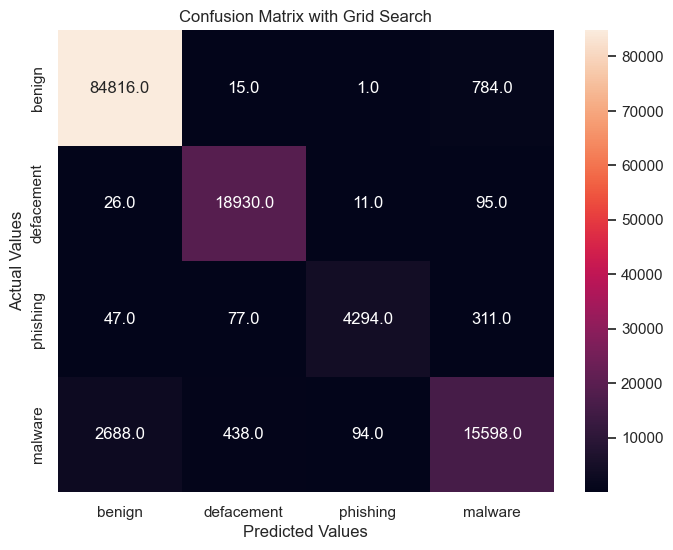

In [62]:
cm_best = confusion_matrix(y_test, y_pred_rf_best)
cm_df_best = pd.DataFrame(cm_best,
                          index=['benign', 'defacement', 'phishing', 'malware'],
                          columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_best, annot=True, fmt=".1f")
plt.title('Confusion Matrix with Grid Search')
plt.ylabel('Actual Values') 
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

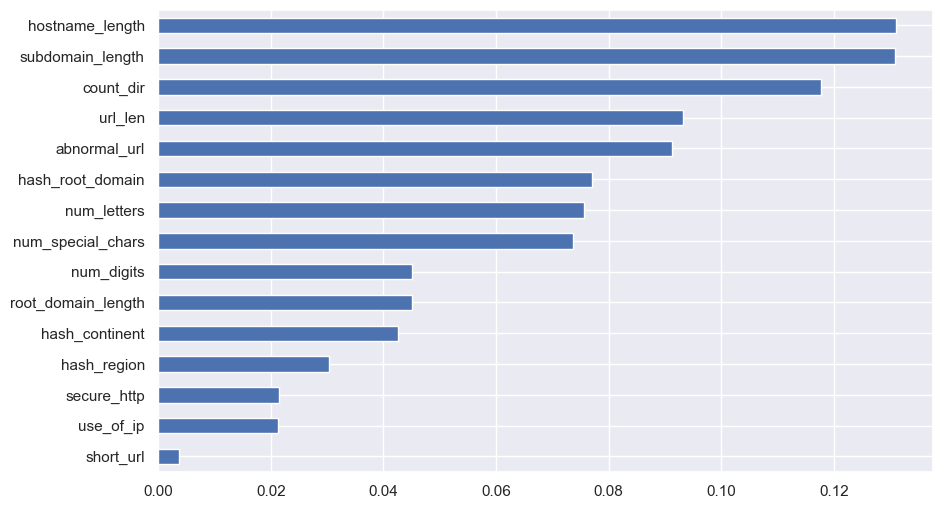

In [63]:
feat_importances = pd.Series(rf_best.best_estimator_.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

### 2. Gradient Boosting Classifier

#### a.) Base Model

In [64]:
gb = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1)

start_train = time.time()
gb.fit(X_train, y_train)
end_train = time.time()

print("Training time for Gradient Boosting: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_gb = gb.predict(X_test)
end_test = time.time()

print("Testing time for Gradient Boosting: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test, y_pred_gb, target_names=['benign', 'defacement', 'phishing', 'malware']))
score = accuracy_score(y_test, y_pred_gb)
print("accuracy: %0.3f" % score)

Training time for Gradient Boosting: 428.564 seconds
Testing time for Gradient Boosting: 0.681 seconds
              precision    recall  f1-score   support

      benign       0.93      0.99      0.96     85616
  defacement       0.89      0.96      0.92     19062
    phishing       0.96      0.79      0.87      4729
     malware       0.89      0.58      0.70     18818

    accuracy                           0.92    128225
   macro avg       0.92      0.83      0.86    128225
weighted avg       0.92      0.92      0.91    128225

accuracy: 0.917


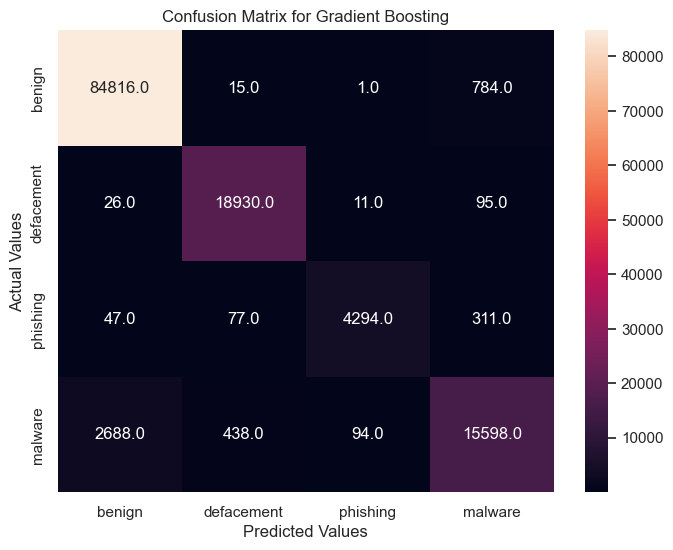

In [65]:
cm_best = confusion_matrix(y_test, y_pred_rf_best)
cm_df_best = pd.DataFrame(cm_best,
                          index=['benign', 'defacement', 'phishing', 'malware'],
                          columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_best, annot=True, fmt=".1f")  
plt.title('Confusion Matrix for Gradient Boosting')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

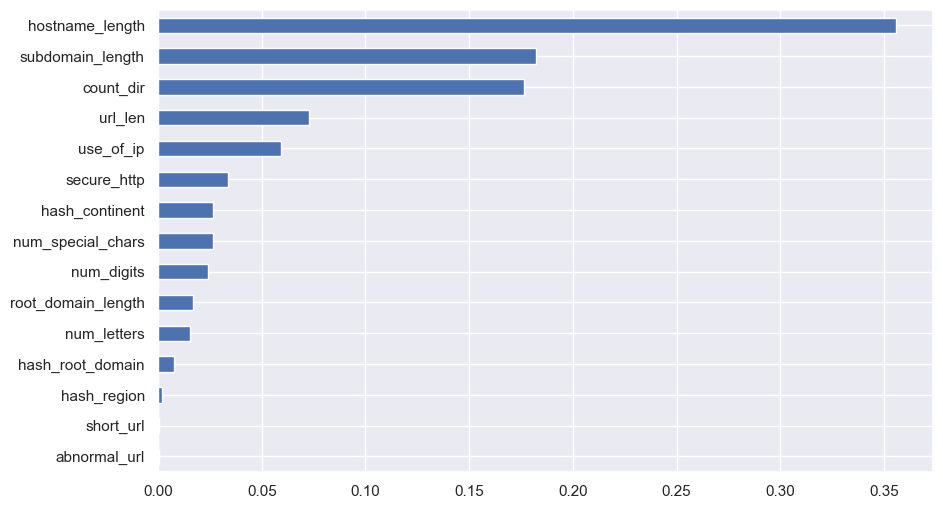

In [66]:
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

#### b.) Grid Search

In [79]:
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), gb_grid, cv=2)

start_train = time.time()
gb_best = grid_search_gb.fit(X_train, y_train)
end_train = time.time()
print("Training time for Gradient Boosting with Grid Search: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_gb_best = gb_best.predict(X_test)
end_test = time.time()

print("Testing time for Gradient Boosting with Grid Search: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test, y_pred_gb_best, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = accuracy_score(y_test, y_pred_gb_best)
print("accuracy: %0.3f" % score)

Training time for Gradient Boosting with Grid Search: 1724.891 seconds
Testing time for Gradient Boosting with Grid Search: 1.514 seconds
              precision    recall  f1-score   support

      benign       0.94      0.99      0.96     85616
  defacement       0.91      0.97      0.94     19062
    phishing       0.97      0.81      0.88      4729
     malware       0.90      0.68      0.77     18818

    accuracy                           0.93    128225
   macro avg       0.93      0.86      0.89    128225
weighted avg       0.93      0.93      0.93    128225

accuracy: 0.933


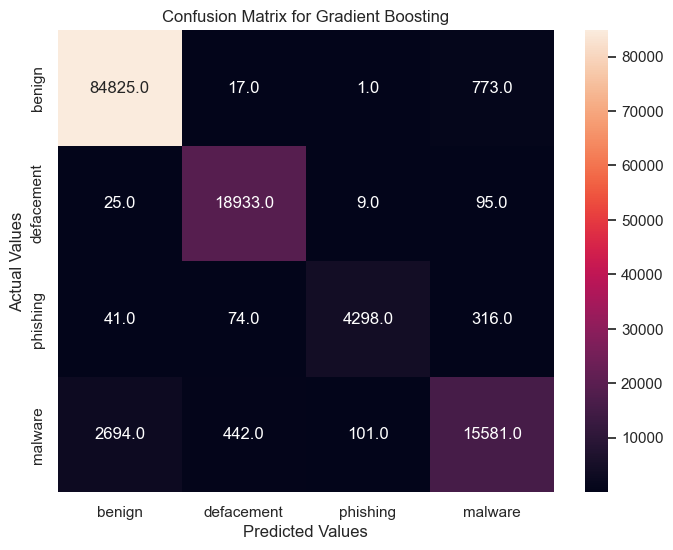

In [80]:
cm_best = confusion_matrix(y_test, y_pred_rf_best)
cm_df_best = pd.DataFrame(cm_best,
                          index=['benign', 'defacement', 'phishing', 'malware'],
                          columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_best, annot=True, fmt=".1f")  
plt.title('Confusion Matrix for Gradient Boosting')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

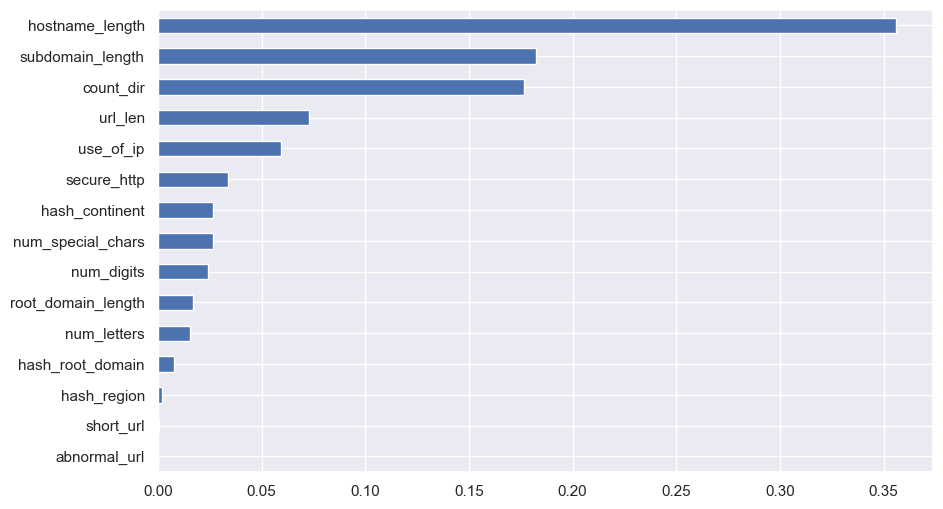

In [81]:
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

### 4. Light GBM Classifier

In [67]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt', n_jobs = 5,
        silent = True, random_state=5)

start_train = time.time()
LGB_C = lgb.fit(X_train, y_train)
end_train = time.time()

print("Training time for LightGBM: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_lgb = LGB_C.predict(X_test)
end_test = time.time()
print("Testing time for LightGBM: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test,y_pred_lgb, target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_lgb)
print("accuracy: %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 512900, number of used features: 15
[LightGBM] [Info] Start training from score -0.403914
[LightGBM] [Info] Start training from score -1.906116
[LightGBM] [Info] Start training from score -3.300073
[LightGBM] [Info] Start training from score -1.918946
Training time for LightGBM: 4.988 seconds
[LightGBM] [Warning] Unknown parameter: silent


c:\Users\HomePC\Documents\4th Year JKUAT\Project\Malicious URLs\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Testing time for LightGBM: 0.532 seconds
              precision    recall  f1-score   support

      benign       0.96      0.99      0.97     85616
  defacement       0.95      0.99      0.97     19062
    phishing       0.97      0.87      0.91      4729
     malware       0.92      0.76      0.83     18818

    accuracy                           0.95    128225
   macro avg       0.95      0.90      0.92    128225
weighted avg       0.95      0.95      0.95    128225

accuracy: 0.951


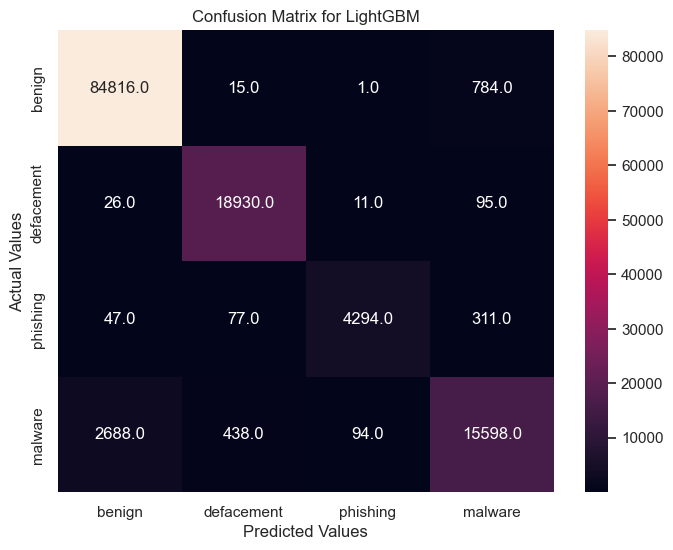

In [68]:
cm_best = confusion_matrix(y_test, y_pred_rf_best)
cm_df_best = pd.DataFrame(cm_best,
                          index=['benign', 'defacement', 'phishing', 'malware'],
                          columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_best, annot=True, fmt=".1f")
plt.title('Confusion Matrix for LightGBM')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

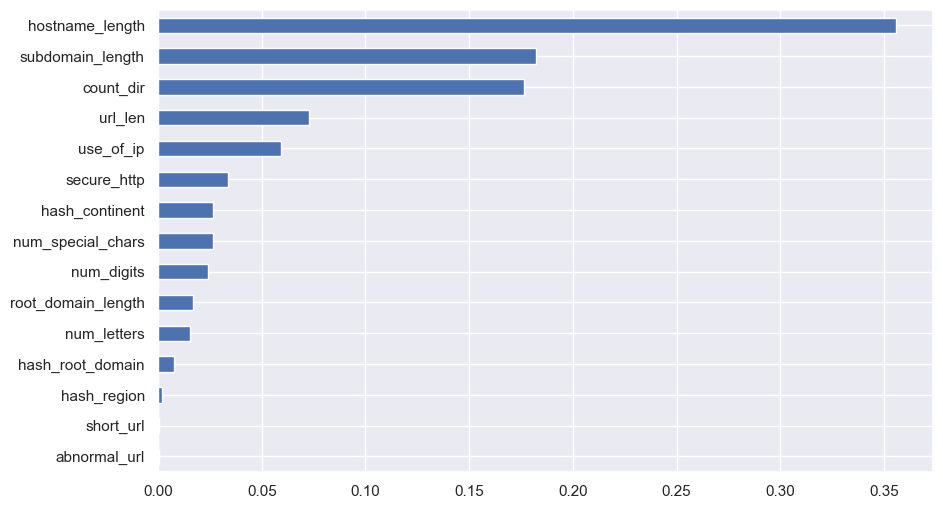

In [69]:
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

#### 5. XGBoost Classifier


In [70]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)

start_train = time.time()
xgb_c.fit(X_train,y_train)
end_train = time.time()

print("Training time for XGBoost: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_x = xgb_c.predict(X_test)
end_test = time.time()

print("Testing time for XGBoost: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_x)
print("accuracy: %0.3f" % score)

Training time for XGBoost: 5.945 seconds
Testing time for XGBoost: 0.148 seconds
              precision    recall  f1-score   support

      benign       0.96      0.99      0.98     85616
  defacement       0.96      0.99      0.97     19062
    phishing       0.98      0.89      0.93      4729
     malware       0.93      0.79      0.86     18818

    accuracy                           0.96    128225
   macro avg       0.96      0.92      0.93    128225
weighted avg       0.96      0.96      0.96    128225

accuracy: 0.958


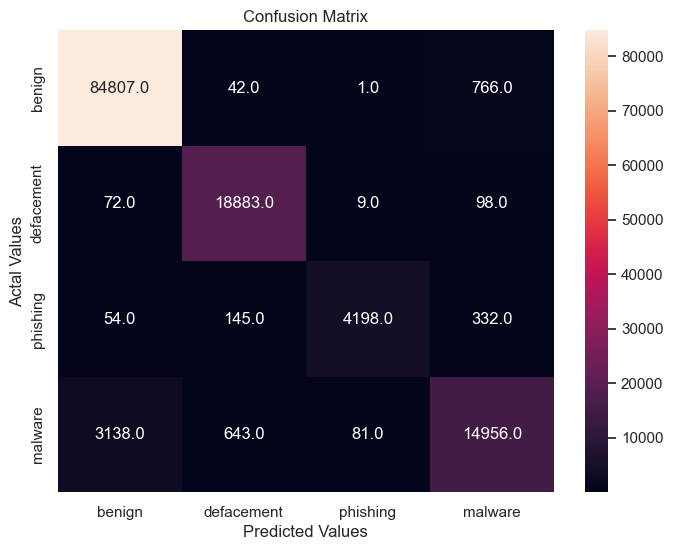

In [71]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                    index = ['benign', 'defacement','phishing','malware'],
                    columns = ['benign', 'defacement','phishing','malware' ])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

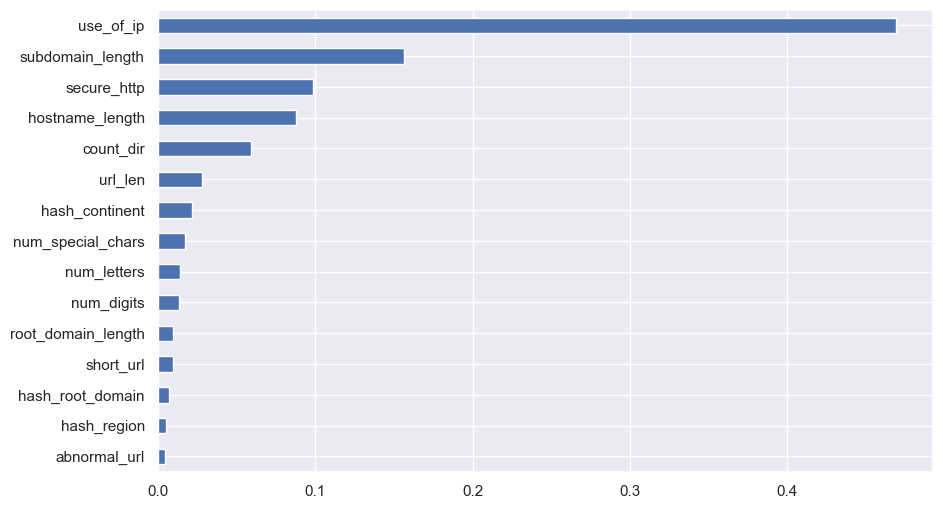

In [72]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X.columns)
feat_importances. sort_values().plot(kind="barh",figsize=(10, 6))

In [73]:
selected_features_indices = feature_selector.get_support(indices=True)
selected_features = X.columns[selected_features_indices]

# Train a XGBoost model with selected features
X_train_selected = X_train[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]
xgb_selected = xgb.XGBClassifier(n_estimators=100)  
start_train = time.time()
xgb_selected.fit(X_train_selected, y_train) 
end_train = time.time()
print("Training time for XGBoost with selected features: %0.3f seconds" % (end_train - start_train))
start_test = time.time()
y_pred_x_selected = xgb_selected.predict(X_test_selected)
end_test = time.time()
print("Testing time for XGBoost with selected features: %0.3f seconds" % (end_test - start_test))
print(classification_report(y_test, y_pred_x_selected, target_names=['benign', 'defacement', 'phishing', 'malware']))
score = accuracy_score(y_test, y_pred_x_selected)
print("accuracy: %0.3f" % score)

Training time for XGBoost with selected features: 4.659 seconds
Testing time for XGBoost with selected features: 0.136 seconds
              precision    recall  f1-score   support

      benign       0.93      0.99      0.96     85616
  defacement       0.91      0.97      0.94     19062
    phishing       0.97      0.85      0.91      4729
     malware       0.90      0.63      0.74     18818

    accuracy                           0.93    128225
   macro avg       0.93      0.86      0.89    128225
weighted avg       0.93      0.93      0.92    128225

accuracy: 0.926


### Neural Network Model

#### 1. MLP Classifier

In [74]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter=500)

start_train = time.time()
clf.fit(X_train, y_train)
end_train = time.time()
print("Training time for MLPClassifier: %0.3f seconds" % (end_train - start_train))

start_test = time.time()
y_pred_mlp = clf.predict(X_test)
end_test = time.time()

print("Testing time for MLPClassifier: %0.3f seconds" % (end_test - start_test))
print(classification_report(y_test, y_pred_mlp, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = accuracy_score(y_test, y_pred_mlp)
print("accuracy: %0.3f" % score)


Training time for MLPClassifier: 112.460 seconds
Testing time for MLPClassifier: 0.025 seconds
              precision    recall  f1-score   support

      benign       0.91      0.97      0.94     85616
  defacement       0.86      0.94      0.89     19062
    phishing       0.88      0.62      0.73      4729
     malware       0.72      0.47      0.57     18818

    accuracy                           0.88    128225
   macro avg       0.84      0.75      0.78    128225
weighted avg       0.87      0.88      0.87    128225

accuracy: 0.880


c:\Users\HomePC\Documents\4th Year JKUAT\Project\Malicious URLs\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


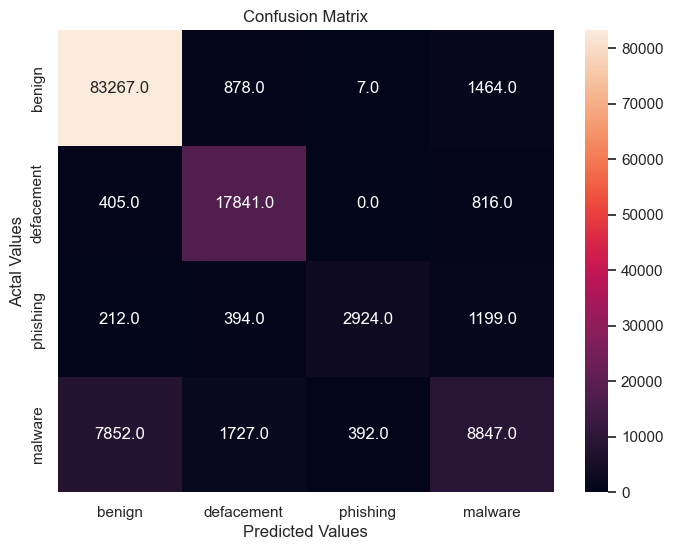

In [75]:
cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm,
                    index = ['benign', 'defacement','phishing','malware'],
                    columns = ['benign', 'defacement','phishing','malware'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

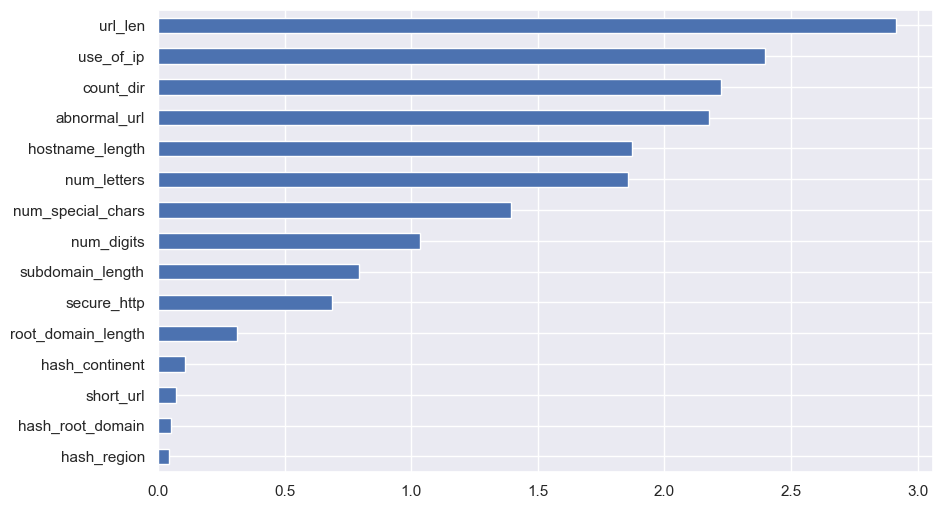

In [76]:
feat_weights = np.mean(np.abs(clf.coefs_[0]), axis=1)

feat_importances = pd.Series(feat_weights, index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

### 2. Adam Model

In [77]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(4, activation='softmax'))  

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

start_train = time.time()
model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_split=0.2)
end_train = time.time()

start_test = time.time()
y_pred_nn = model.predict(X_test)
end_test = time.time()

y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
print("Training time for Neural Network: %0.3f seconds" % (end_train - start_train))

print("Testing time for Neural Network: %0.3f seconds" % (end_test - start_test))

print(classification_report(y_test, y_pred_nn_classes, target_names=['benign', 'defacement', 'phishing', 'malware']))
score = accuracy_score(y_test, y_pred_nn_classes)
print("accuracy: %0.3f" % score)


c:\Users\HomePC\Documents\4th Year JKUAT\Project\Malicious URLs\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8607 - loss: 0.3891 - val_accuracy: 0.9107 - val_loss: 0.2456
Epoch 2/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9196 - loss: 0.2343 - val_accuracy: 0.9309 - val_loss: 0.2135
Epoch 3/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9314 - loss: 0.2117 - val_accuracy: 0.9313 - val_loss: 0.2111
Epoch 4/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9345 - loss: 0.2073 - val_accuracy: 0.9388 - val_loss: 0.2024
Epoch 5/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9369 - loss: 0.2019 - val_accuracy: 0.9397 - val_loss: 0.2000
Epoch 6/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9383 - loss: 0.1991 - val_accuracy: 0.9379 - val_loss: 0.2051
Epoch 7/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9384 - loss: 0.1991 - val_accuracy: 0.9374 - val_loss: 0.2030
Epoch 8/20
12823/12823 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 

In [81]:
print("Training time for Neural Network: %0.3f seconds" % (end_train - start_train))

Training time for Neural Network: 482.736 seconds


In [82]:
print("Testing time for Neural Network: %0.3f seconds" % (end_test - start_test))

Testing time for Neural Network: 4.710 seconds


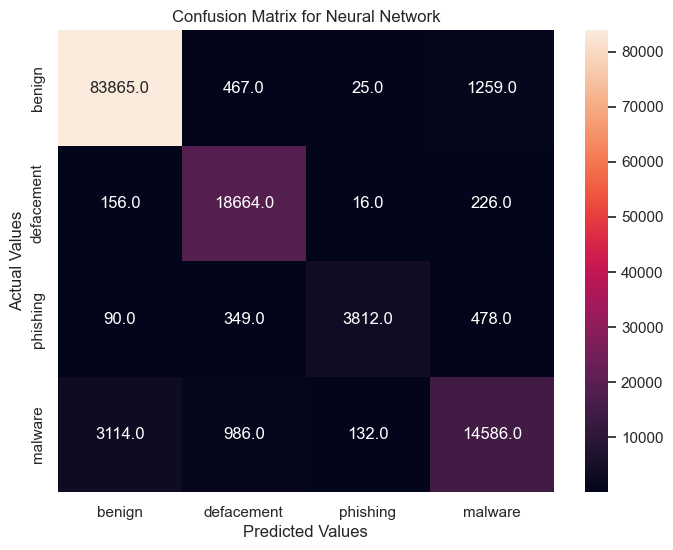

In [79]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
cm_df = pd.DataFrame(cm,
                    index=['benign', 'defacement', 'phishing', 'malware'],
                    columns=['benign', 'defacement', 'phishing', 'malware'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".1f")   
plt.title('Confusion Matrix for Neural Network')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

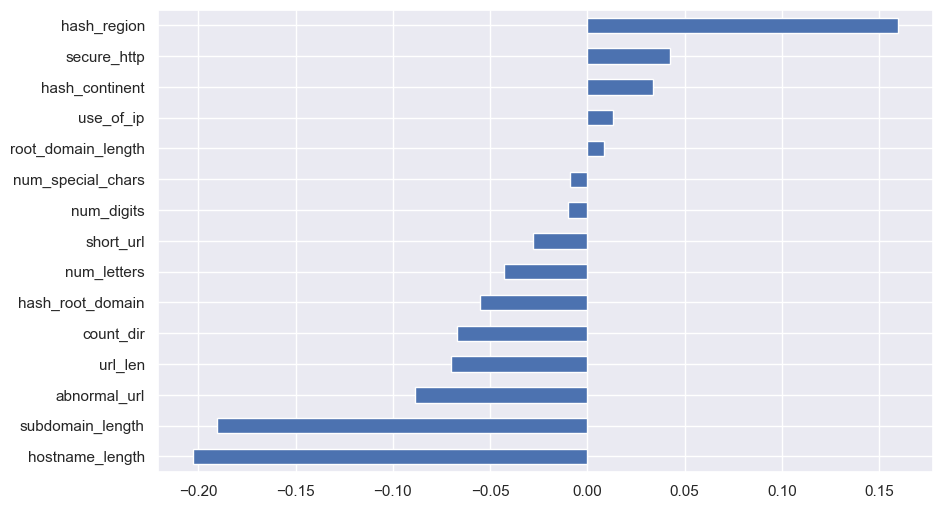

In [80]:
feat_importances = pd.Series(model.layers[0].get_weights()[0].mean(axis=1), index=X.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(10, 6))

In [97]:
# Evaluation

def evaluate_model(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred), 
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "ROC-AUC": roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
    }


In [105]:
rf_results = evaluate_model(y_test, rf_best.predict(X_test), rf_best.predict_proba(X_test)) 
## svm_results = evaluate_model(y_test, svm_best.predict(X_test), svm_best.predict_proba(X_test))
gb_results = evaluate_model(y_test, gb_best.predict(X_test), gb_best.predict_proba(X_test))
nn_proba = model.predict(X_test)  
nn_pred = np.argmax(nn_proba, axis=1) 
nn_results = evaluate_model(y_test, nn_pred, nn_proba)

print("Random Forest:", rf_results)
## print("SVM:", svm_results)
print("Gradient Boosting:", gb_results)
print("Neural Network:", nn_results)

4008/4008 ━━━━━━━━━━━━━━━━━━━━ 4s 882us/step
Random Forest: {'Accuracy': 0.964219146032365, 'Precision': 0.9635957390181599, 'Recall': 0.964219146032365, 'ROC-AUC': np.float64(0.993392984049215)}
Gradient Boosting: {'Accuracy': 0.9331175667771495, 'Precision': 0.9320874543840467, 'Recall': 0.9331175667771495, 'ROC-AUC': np.float64(0.9783479478277785)}
Neural Network: {'Accuracy': 0.9411503217001365, 'Precision': 0.9409017751761396, 'Recall': 0.9411503217001365, 'ROC-AUC': np.float64(0.9823560512589768)}


## Results

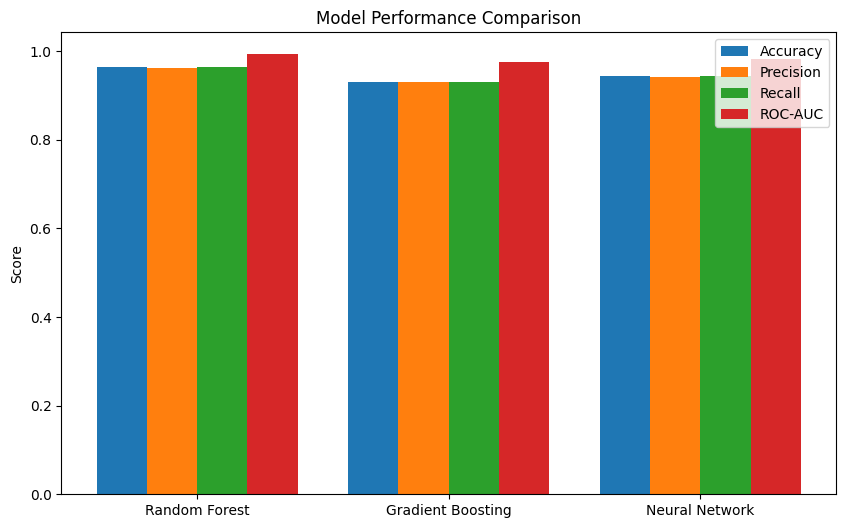

In [82]:
# Collect results
model_names = ["Random Forest", "Gradient Boosting", "Neural Network"]
metrics = ["Accuracy", "Precision", "Recall", "ROC-AUC"]

results = {
    "Random Forest": rf_results,
    "Gradient Boosting": gb_results,
    "Neural Network": nn_results
}

# Prepare data for plotting
metric_values = {metric: [results[model][metric] for model in model_names] for metric in metrics}

# Plotting
x = range(len(model_names))
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar([p + i * width for p in x], metric_values[metric], width, label=metric)

# Add labels, title, and legend
ax.set_xticks([p + 1.5 * width for p in x])
ax.set_xticklabels(model_names)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend(loc="best")

plt.show()